In [1]:
from netCDF4 import Dataset
# from wrf import getvar, interp
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import cartopy.feature as cfeature
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

### _path to cold start and restart files_

In [2]:
path = '/glade/scratch/noteng/lab3/WRF/test/em_real/cold_start/wrfout_d01_1998-08-01_00:00:00'
path1 = '/glade/scratch/noteng/lab3/WRF/test/em_real/restart/wrfout_d01_1998-08-02_03:00:00'

In [3]:
# Open the NetCDF file
ncfile = Dataset(path)  #path to cold start files
ncfile1 = Dataset(path1) #path to restart files

### _create a function to calculate wind speed of both u and v components of the wind_

In [4]:
def wind_uv_speed(u,v):
    WSpd = (np.sqrt(np.square(u)+np.square(v)))
    return WSpd

# wrf countour wind plot function

In [5]:
def wrf_contour_wind_plot(ncfile, pressure_level, levels, cmap='jet', resolution='110m'):
    
    # Extract the pressure, geopotential height, and wind variables
    p = getvar(ncfile, "pressure"); z = getvar(ncfile, "z")
    ua = getvar(ncfile, "ua"); va = getvar(ncfile, "va")
   
    # Interpolate geopotential height, u, and v winds to the pressure level
    hgt = interplevel(z, p, pressure_level); u = interplevel(ua, p, pressure_level) 
    v = interplevel(va, p, pressure_level)

    # Get the lat/lon coordinates
    lats, lons = latlon_coords(hgt)

    # get the WRF local cosine and sines of the map rotation
    cosalpha = ncfile.variables['COSALPHA'][0]
    sinalpha = ncfile.variables['SINALPHA'][0]
    
    # rotate grid-relative winds to earth-relative using the correct formulas
    ue = u * cosalpha - v * sinalpha
    ve = v * cosalpha + u * sinalpha

    # calculate new wind speed using the rotated winds
    wspd = wind_uv_speed(ue,ve)
    
    # Get the map projection information
    cart_proj = get_cartopy(hgt)

    # Create the figure
    fig = plt.figure(figsize=(14,10))
    fig.patch.set_facecolor('xkcd:white') #Set the background = ‘white'
    ax = plt.axes(projection=cart_proj)
    ax.coastlines(resolution, linewidth=1)
    ax.add_feature(cfeature.BORDERS)


        
    contours = plt.contour(to_np(lons), to_np(lats), to_np(hgt), #levels=level, 
                           colors="black", transform=crs.PlateCarree())

    # Add the wind speed contours
    wspd_contours = plt.contourf(to_np(lons), to_np(lats), to_np(wspd), levels=levels,
                                 cmap=get_cmap(cmap), transform=crs.PlateCarree(), extend='both')
    
    # Add the wind barbs, only plotting every 10th data point.
    plt.barbs(to_np(lons[::10,::10]), to_np(lats[::10,::10]), to_np(ue[::10, ::10]), 
              to_np(ve[::10, ::10]), transform=crs.PlateCarree(), length=6)
    
    # Set the map bounds and axes title
    ax.set(xlim=(cartopy_xlim(hgt)),ylim=(cartopy_ylim(hgt)) )

    gl = ax.gridlines(x_inline=False); gl.bottom_labels=True; gl.left_labels=True
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'red', 'weight': 'bold', 'rotation': 45}; gl.ylabel_style = {'color': 'green', 'weight': 'bold'}

    cax = fig.add_axes([0.16,0.04,0.7,0.04])
    cbar = plt.colorbar(wspd_contours, cax=cax, orientation="horizontal", pad=.05, shrink=1, aspect=12, ticks=levels)
    cbar.set_label('Wind Speed ($ms^{-1}$)', fontsize=12)

    ax.set_title(f'Earth-relative winds at {pressure_level} MB', fontsize = 16)

# QUESTION ONE AND TWO

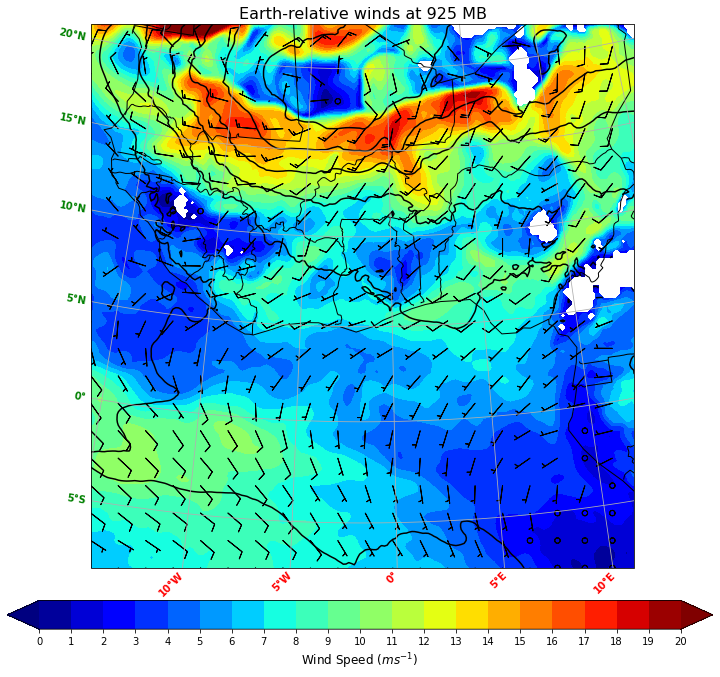

In [6]:
wrf_contour_wind_plot(ncfile, 925, levels=np.arange(0, 21, 1))

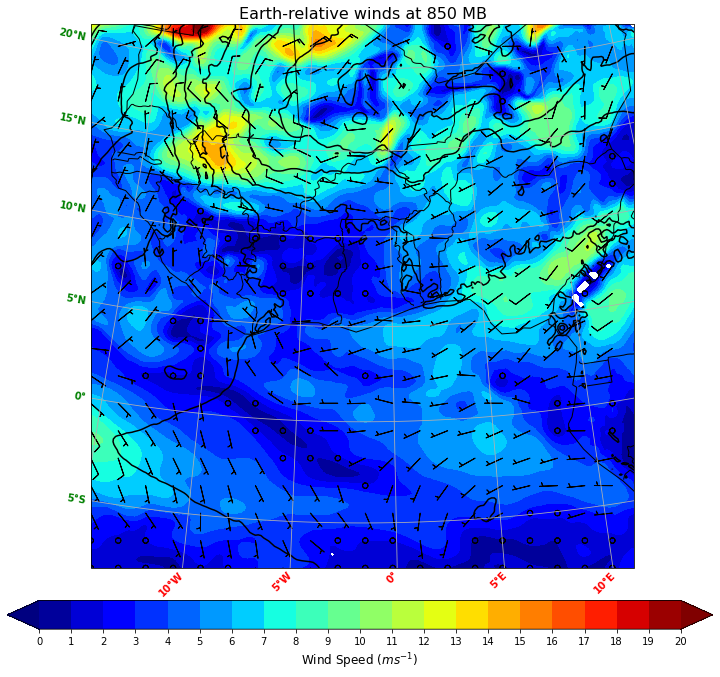

In [7]:
wrf_contour_wind_plot(ncfile, 850, levels=np.arange(0, 21, 1))

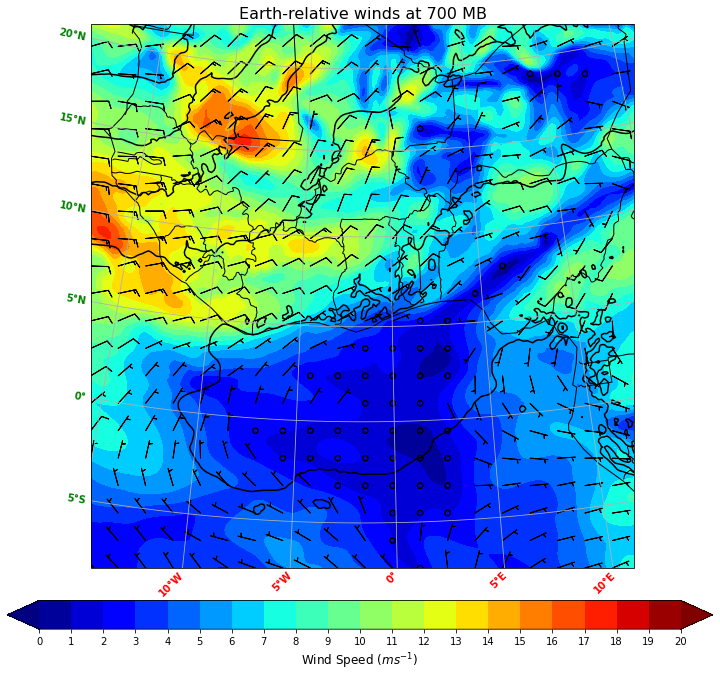

In [8]:
wrf_contour_wind_plot(ncfile, 700, levels=np.arange(0, 21, 1))

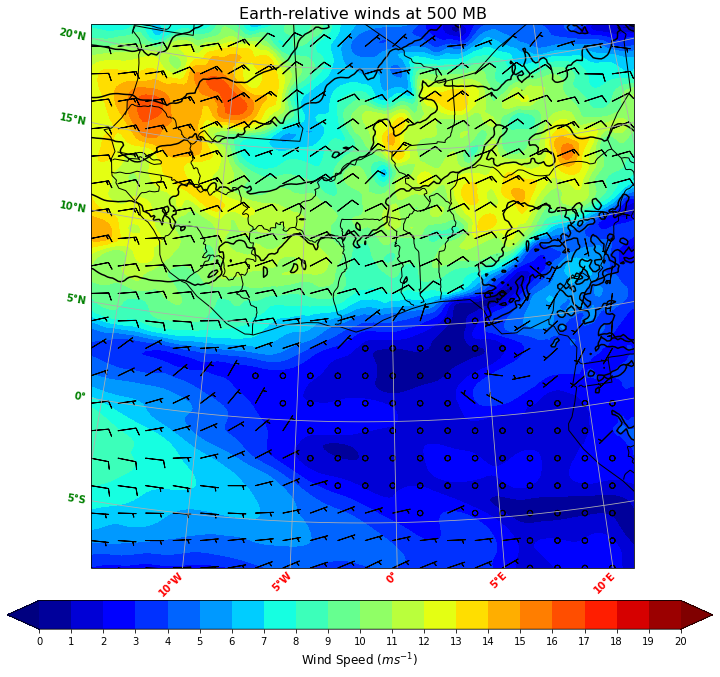

In [9]:
wrf_contour_wind_plot(ncfile, 500, levels=np.arange(0, 21, 1))

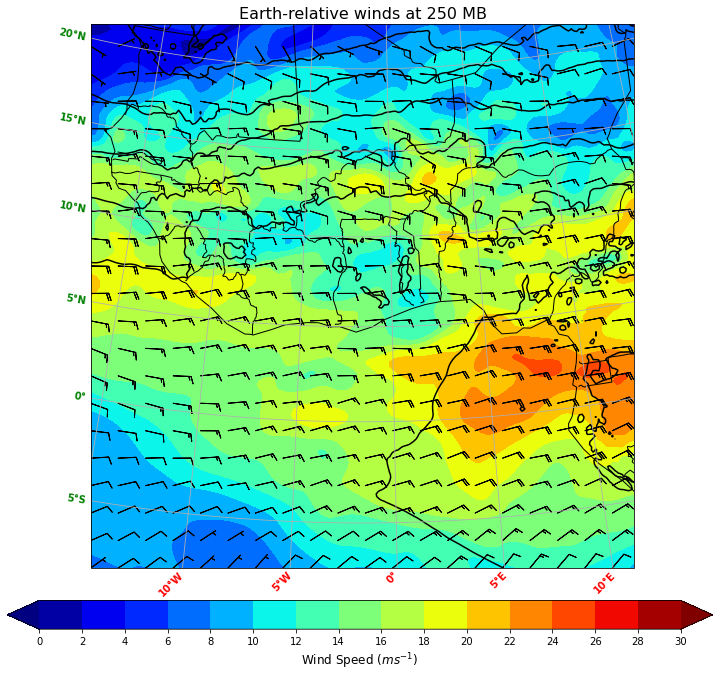

In [10]:
wrf_contour_wind_plot(ncfile, 250, levels=np.arange(0, 31, 2))

# QUESTION 3

## Let's first define functions to calculate dx, dy and the geostrophic wind components

In [11]:
def dxdy(longitude, latitude, shape='sphere', radius=6370997.):
    """ This definition calculates the distance between grid points that are in
        a latitude/longitude format.

        Using pyproj GEOD; different Earth Shapes
        https://jswhit.github.io/pyproj/pyproj.Geod-class.html

        Common shapes: 'sphere', 'WGS84', 'GRS80'

        Accepts, 1D or 2D arrays for latitude and longitude

        Assumes [Y, X] for 2D arrays

        Returns: dx, dy; 2D arrays of distances between grid points
                 in the x and y direction with units of meters and sign of differencing
    """
    import numpy as np
    from metpy.units import units
    from pyproj import Geod
    
    if radius != 6370997.:
        g = Geod(a=radius, b=radius)
    else:
        g = Geod(ellps=shape)

    if latitude.ndim == 1:
        longitude, latitude = np.meshgrid(longitude, latitude)

    dy = np.zeros(latitude.shape)
    dx = np.zeros(longitude.shape)

    for i in range(longitude.shape[1]):
        for j in range(latitude.shape[0]-1):
            _, _, dy[j, i] = g.inv(longitude[j, i], latitude[j, i],
                                   longitude[j+1, i], latitude[j+1, i])
    dy[j+1, :] = dy[j, :]

    for i in range(longitude.shape[1]-1):
        for j in range(latitude.shape[0]):
            _, _, dx[j, i] = g.inv(longitude[j, i], latitude[j, i],
                                   longitude[j, i+1], latitude[j, i+1])
    dx[:, i+1] = dx[:, i]

    xdiff_sign = np.sign(longitude[0, 1] - longitude[0, 0])
    ydiff_sign = np.sign(latitude[1, 0] - latitude[0, 0])
    
    return (xdiff_sign.values)*dx, (ydiff_sign.values)*dy



#**** Code to calculate u and v of geostrophic wind ****

#plt.switch_backend('agg')
def calc_geo_wind(longitude,latitude, hght, f):
    dx, dy = dxdy(longitude,latitude)

    hghtroll_x = np.roll(hght,-1, axis= 1)
    hght_x = np.roll(hght, 1, axis = 1)
    hghtroll_y = np.roll(hght, -1, axis = 0)
    hght_y = np.roll(hght, 1, axis = 0)
    DH_x = hghtroll_x - hght_x
    DH_y = hghtroll_y - hght_y

    gr = 9.81
    dd_x =((DH_x)/(2*dx))
    dd_y= ((DH_y)/(2*dy))
    
    #Calculate the geostrophic wind components ug and vg
    u_geo = (-gr/f) * (dd_y)
    v_geo = (gr/f) * (dd_x)

    return u_geo, v_geo

### Defining a plotting function for ageostrophic wind

In [12]:
def wrf_contour_wind_ageo_plot(ncfile, pressure_level, levels, cmap='jet', resolution='110m'):
    
    # Extract the pressure, geopotential height, and wind variables
    p = getvar(ncfile, "pressure"); z = getvar(ncfile, "z")
    ua = getvar(ncfile, "ua"); va = getvar(ncfile, "va")
    F = getvar(ncfile, 'F'); 
    
    # Interpolate geopotential height, u, and v winds to the pressure level
    hgt = interplevel(z, p, pressure_level); u = interplevel(ua, p, pressure_level) 
    v = interplevel(va, p, pressure_level)

    # Get the lat/lon coordinates
    lats, lons = latlon_coords(hgt)

    #Calculate the geostrophic wind components ug and uv
    Ug, Vg = calc_geo_wind(lons, lats, hgt, F)

    #Now calculate the ageostrophic wind components
    U_Ag = u - Ug
    V_Ag = v - Vg
    
    # get the WRF local cosine and sines of the map rotation
    cosalpha = ncfile.variables['COSALPHA'][0]
    sinalpha = ncfile.variables['SINALPHA'][0]
    
    # rotate grid-relative winds to earth-relative using the correct formulas
    ue = U_Ag * cosalpha - V_Ag * sinalpha
    ve = V_Ag * cosalpha + U_Ag * sinalpha

    # calculate new wind speed using the rotated winds
    wspd = wind_uv_speed(ue,ve)
    
    # Get the map projection information
    cart_proj = get_cartopy(hgt)

    # Create the figure
    fig = plt.figure(figsize=(14,10))
    fig.patch.set_facecolor('xkcd:white') #Set the background = ‘white'
    ax = plt.axes(projection=cart_proj)
    ax.coastlines(resolution, linewidth=1)
    ax.add_feature(cfeature.BORDERS)

        
    contours = plt.contour(to_np(lons), to_np(lats), to_np(hgt), #levels=level, 
                           colors="black", transform=crs.PlateCarree())

    # Add the wind speed contours
    wspd_contours = plt.contourf(to_np(lons), to_np(lats), to_np(wspd), levels=levels,
                                 cmap=get_cmap(cmap), transform=crs.PlateCarree(), extend='both')
    
    # Add the wind barbs, only plotting every 10th data point.
    plt.barbs(to_np(lons[::10,::10]), to_np(lats[::10,::10]), to_np(ue[::10, ::10]), 
              to_np(ve[::10, ::10]), transform=crs.PlateCarree(), length=6)
    
    # Set the map bounds and axes title
    ax.set(xlim=(cartopy_xlim(hgt)),ylim=(cartopy_ylim(hgt)) )

    gl = ax.gridlines(x_inline=False); gl.bottom_labels=True; gl.left_labels=True
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'red', 'weight': 'bold', 'rotation': 45}; gl.ylabel_style = {'color': 'green', 'weight': 'bold'}

    cax = fig.add_axes([0.16,0.04,0.7,0.04])
    cbar = plt.colorbar(wspd_contours, cax=cax, orientation="horizontal", pad=.05, shrink=1, aspect=12, ticks=levels)
    cbar.set_label('Wind Speed ($ms^{-1}$)', fontsize=12)

    ax.set_title(f'Earth-relative winds (Ageostrophic) at {pressure_level} MB', fontsize = 16)
    plt.show()


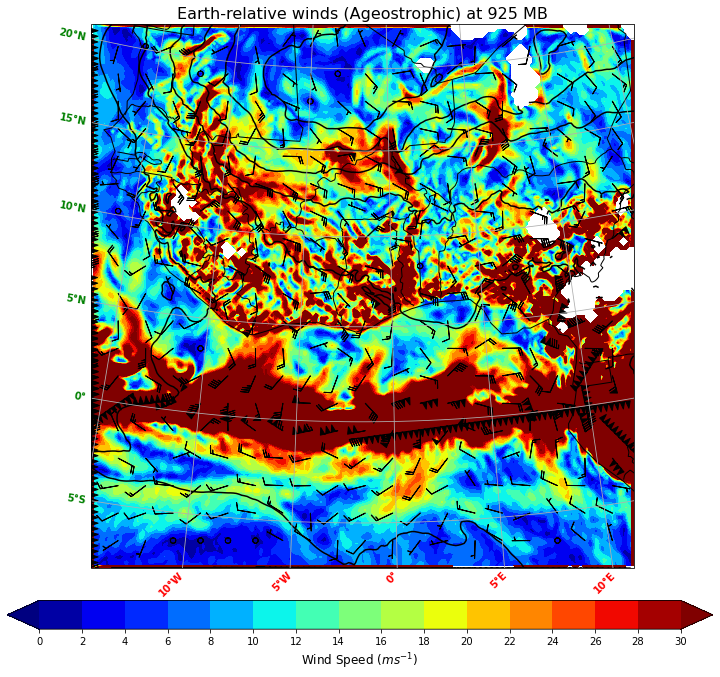

In [13]:
wrf_contour_wind_ageo_plot(ncfile, 925, levels = np.arange(0,31,2))

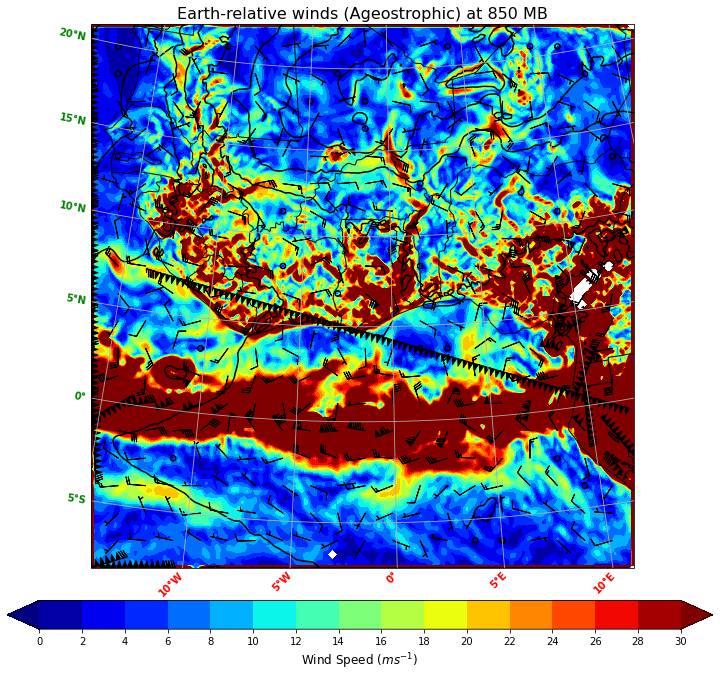

In [14]:
wrf_contour_wind_ageo_plot(ncfile, 850, levels = np.arange(0,31,2))

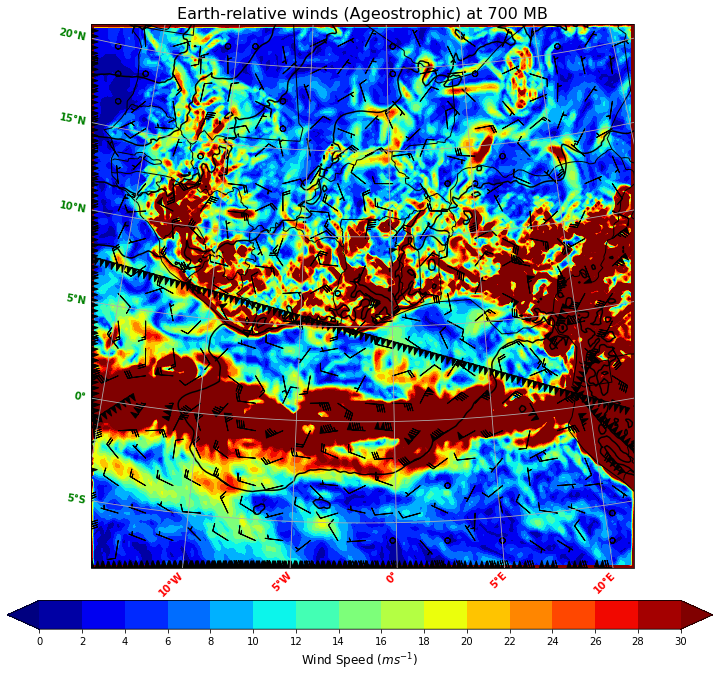

In [15]:
wrf_contour_wind_ageo_plot(ncfile, 700, levels = np.arange(0,32,2))

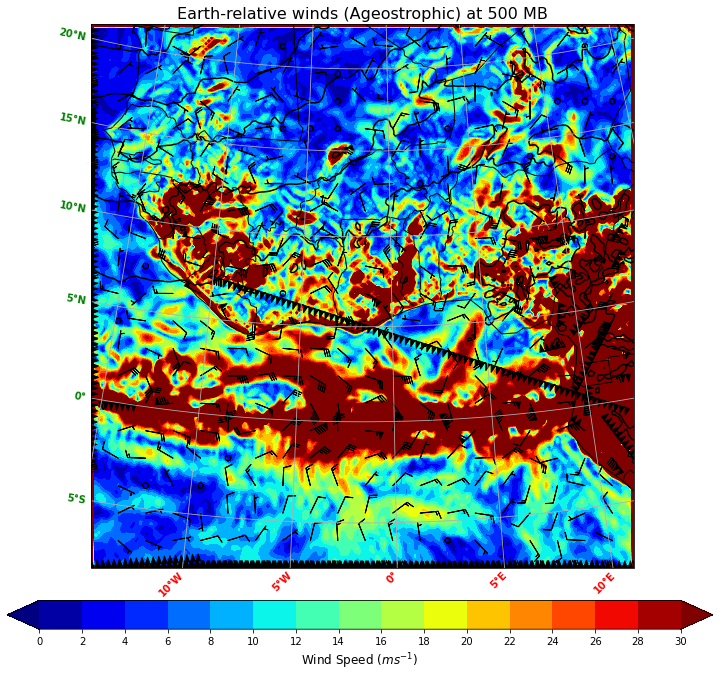

In [16]:
wrf_contour_wind_ageo_plot(ncfile, 500, levels = np.arange(0,32,2))

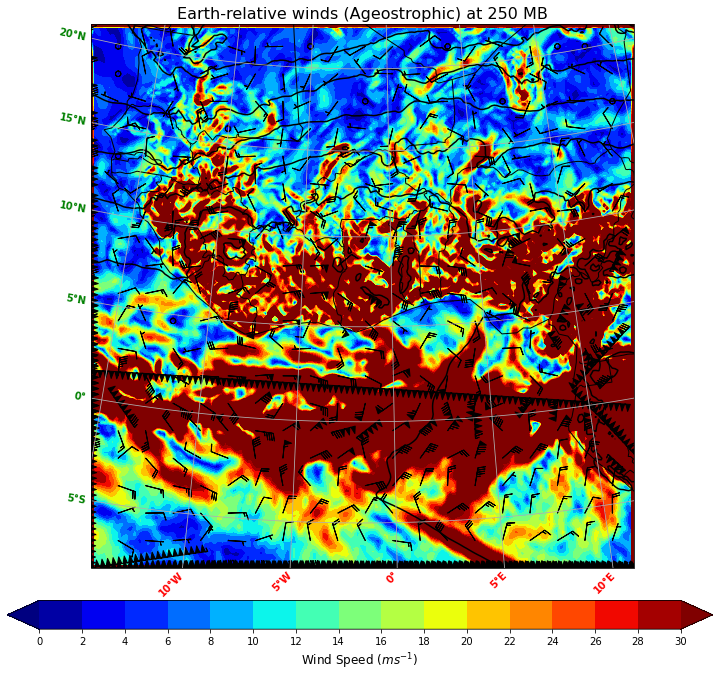

In [17]:
wrf_contour_wind_ageo_plot(ncfile, 250, levels = np.arange(0,32,2))

# QUESTION 4

## _Horizontal Divergence_

In [18]:
def wrf_contour_h_div_plot(ncfile, pressure_level, cmap='jet', resolution='110m'):
    
    # Extract the pressure, geopotential height, and wind variables
    p = getvar(ncfile, "pressure"); z = getvar(ncfile, "z")
    ua = getvar(ncfile, "ua"); va = getvar(ncfile, "va")
   
    # Interpolate geopotential height, u, and v winds to the pressure level
    hgt = interplevel(z, p, pressure_level); ua = interplevel(ua, p, pressure_level) 
    va = interplevel(va, p, pressure_level)
    
    #Find the horizontal divergence of the wind using xarray's finite difference
    dx, dy = 20000, 20000
    u = (ua.diff('x'))/dx
    v = (va.diff('y'))/dy
    
    # Get the lat/lon coordinates
    lats, lons = latlon_coords(hgt)

    # get the WRF local cosine and sines of the map rotation
    cosalpha = ncfile.variables['COSALPHA'][0]
    sinalpha = ncfile.variables['SINALPHA'][0]
    
    # rotate grid-relative winds to earth-relative using the correct formulas
    ue = ua * cosalpha - va * sinalpha
    ve = va * cosalpha + ua * sinalpha

    # calculate new wind speed using the rotated winds
    wspd = wind_uv_speed(u,v)
    
    # Get the map projection information
    cart_proj = get_cartopy(hgt)

    # Create the figure
    fig = plt.figure(figsize=(14,10))
    fig.patch.set_facecolor('xkcd:white') #Set the background = ‘white'
    ax = plt.axes(projection=cart_proj)
    ax.coastlines(resolution, linewidth=1)
    ax.add_feature(cfeature.BORDERS)

    # Add the wind speed contours
    wspd_contours = plt.contourf(to_np(lons), to_np(lats), to_np(wspd), #levels=levels,
                                 cmap=get_cmap(cmap), transform=crs.PlateCarree(), extend='both')
    
    # Add the wind barbs, only plotting every 10th data point.
    plt.barbs(to_np(lons[::10,::10]), to_np(lats[::10,::10]), to_np(ue[::10, ::10]), 
              to_np(ve[::10, ::10]), transform=crs.PlateCarree(), length=6)
    
    # Set the map bounds and axes title
    ax.set(xlim=(cartopy_xlim(hgt)),ylim=(cartopy_ylim(hgt)) )

    gl = ax.gridlines(x_inline=False); gl.bottom_labels=True; gl.left_labels=True
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'red', 'weight': 'bold', 'rotation': 45}; gl.ylabel_style = {'color': 'green', 'weight': 'bold'}

    cax = fig.add_axes([0.16,0.04,0.7,0.04])
    cbar = plt.colorbar(wspd_contours, cax=cax, orientation="horizontal", pad=.05, shrink=1, aspect=12)
    cbar.set_label('Wind Speed ($ms^{-1}$)', fontsize=12)

    ax.set_title(f'Earth-relative winds at {pressure_level} MB', fontsize = 16)
    plt.show()

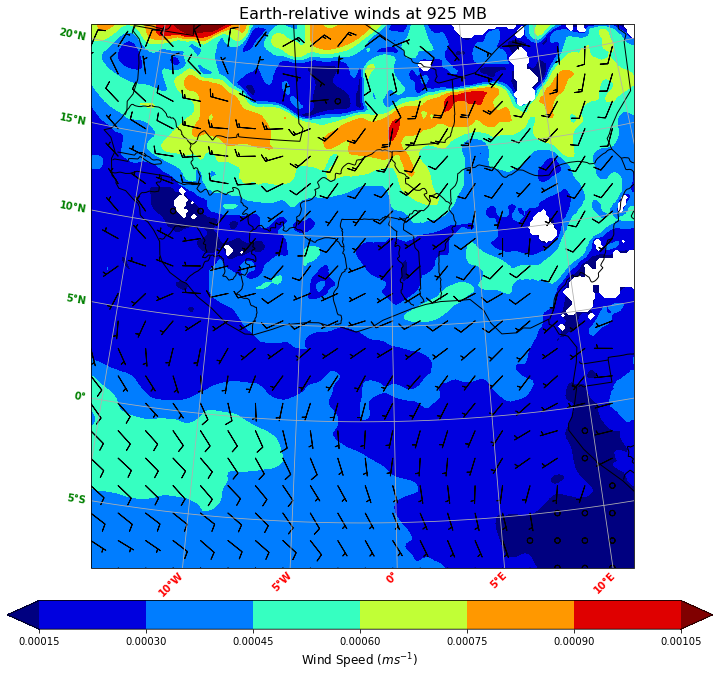

In [19]:
wrf_contour_h_div_plot(ncfile, 925)

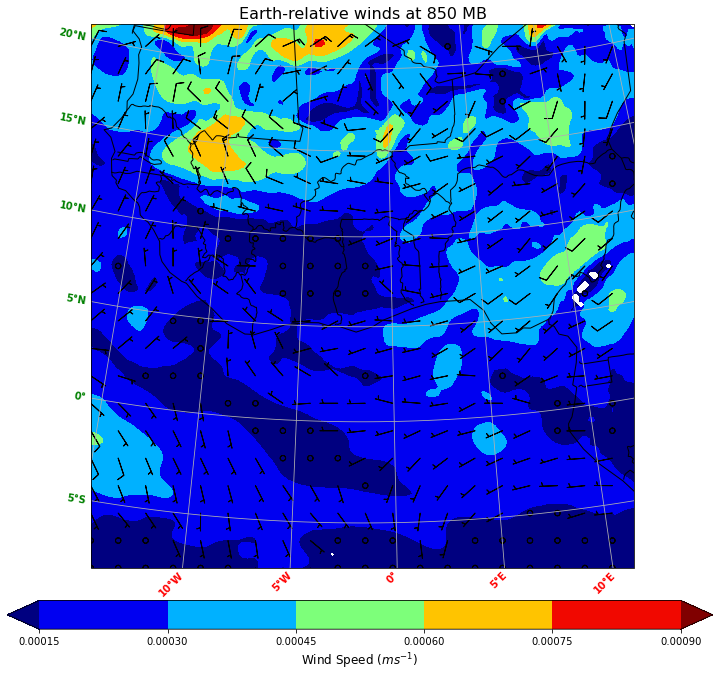

In [20]:
wrf_contour_h_div_plot(ncfile, 850)

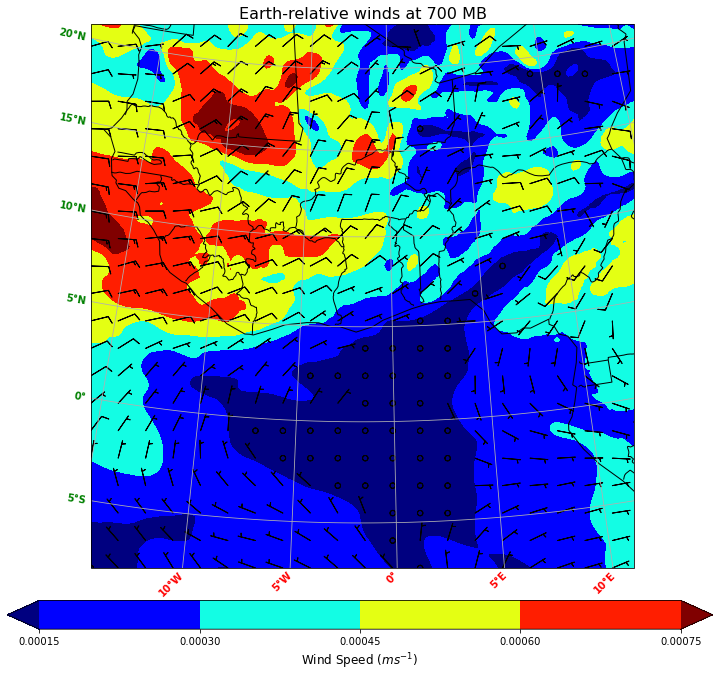

In [21]:
wrf_contour_h_div_plot(ncfile, 700)

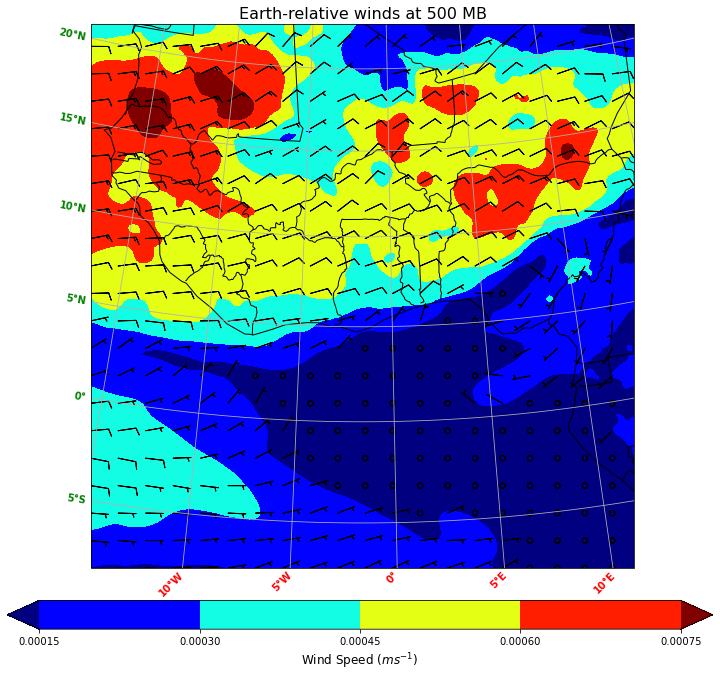

In [22]:
wrf_contour_h_div_plot(ncfile, 500)

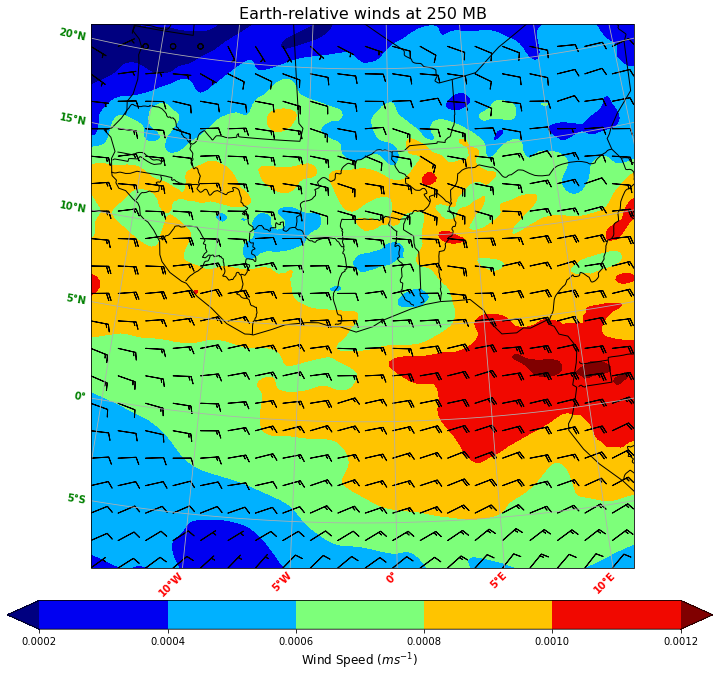

In [23]:
wrf_contour_h_div_plot(ncfile, 250)

# QUESTION 5

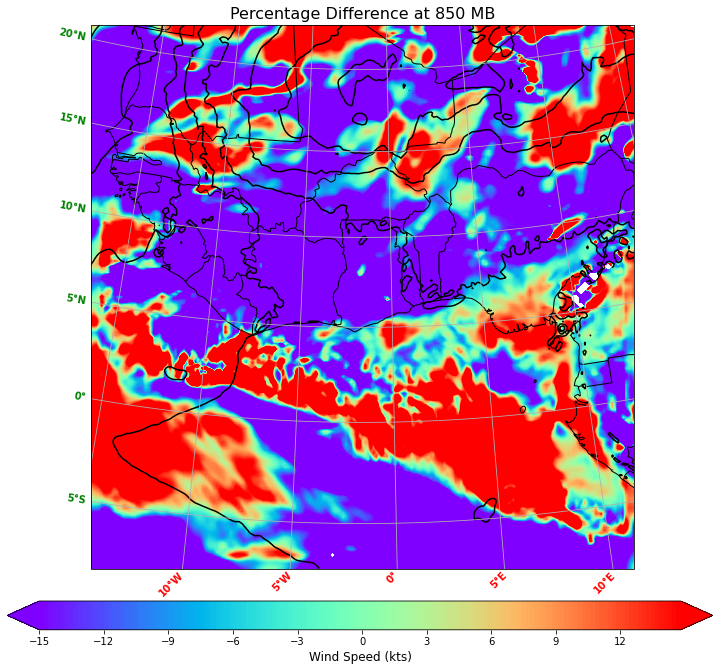

In [24]:
# Extract the pressure, geopotential height, and wind variables
p = getvar(ncfile, "pressure"); z = getvar(ncfile, "z")
p_restart = getvar(ncfile1, "pressure"); z_restart = getvar(ncfile1, "z")


# Interpolate geopotential height, u, and v winds to the pressure level
hgt = interplevel(z, p, 850);# u = interplevel(ua, p, 850)

speed_cold = getvar(ncfile, "wspd_wdir")[0,:]
speed_restart = getvar(ncfile1, "wspd_wdir")[0,:]
speed_cold1 = interplevel(speed_cold, p, 850) 
speed_restart1 = interplevel(speed_restart, p_restart, 850) 

speed_difference = speed_cold1 - speed_restart1
percentage_difference = (speed_difference / (speed_cold1+speed_restart1)) * 100


# Get the lat/lon coordinates
lats, lons = latlon_coords(hgt)

# Get the map projection information
cart_proj = get_cartopy(hgt)

# Create the figure
fig = plt.figure(figsize=(14,10))
fig.patch.set_facecolor('xkcd:white') #Set the background = ‘white'
ax = plt.axes(projection=cart_proj)
ax.coastlines('50m', linewidth=1)
ax.add_feature(cfeature.BORDERS)


 # Add contour to plot       
contours = plt.contour(to_np(lons), to_np(lats), to_np(hgt), #levels=level, 
                           colors="black", transform=crs.PlateCarree())

# Add the wind speed contours
wspd_contours = plt.contourf(to_np(lons), to_np(lats), to_np(percentage_difference), levels=np.arange(-15, 15, 0.2),
                             cmap=get_cmap('rainbow'), transform=crs.PlateCarree(), extend='both')


# Set the map bounds and axes title
ax.set(xlim=(cartopy_xlim(hgt)),ylim=(cartopy_ylim(hgt)) )

gl = ax.gridlines(x_inline=False); gl.bottom_labels=True; gl.left_labels=True
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'red', 'weight': 'bold', 'rotation': 45}; gl.ylabel_style = {'color': 'green', 'weight': 'bold'}

cax = fig.add_axes([0.16,0.04,0.7,0.04])
cbar = plt.colorbar(wspd_contours, cax=cax, orientation="horizontal", pad=.05, shrink=1, aspect=12)
cbar.set_label('Wind Speed (kts)', fontsize=12)

ax.set_title(f'Percentage Difference at 850 MB', fontsize = 16)
plt.show()


<p>
    As a result of the minor difference (Cold_start - Restart winds) compared to the cold start speeds over a small time change, there will be a horizontal advection of the horizontally divergent wind. This strengthens over extremely large time differences.

</p>
